In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
df=pd.read_csv("optimizer_lab_classification_dataset.csv")

In [3]:
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Target
0,-4.906442,3.442789,0.558964,-0.976764,-1.568805,-4.271982,-3.727921,0.111868,2.119795,-2.522812,...,-7.492478,4.264669,0.304866,0.777693,-9.375464,1.654446,3.012859,-4.497003,-2.520066,0
1,2.162610,-5.286651,2.609846,-1.803898,-1.831216,1.450757,2.648709,2.152307,0.524552,0.493548,...,6.680603,-2.431830,2.462773,-1.254824,2.978402,-3.428457,-4.562178,3.698665,-1.923286,1
2,-4.784844,-3.744827,4.657592,-1.408806,-5.444758,-2.416013,3.556495,-1.572119,-0.730549,3.447661,...,7.961059,-5.151105,0.473131,-4.070667,-0.932309,-3.230768,-7.844646,2.803798,-2.963189,1
3,10.465024,1.070944,-3.562432,-0.849062,2.183860,-0.609893,0.946327,-1.046141,-2.057053,-2.056650,...,-1.449095,-1.217685,2.026805,2.121829,3.184256,-1.960146,0.782147,-1.444202,0.915985,0
4,5.599516,-1.776412,-1.304322,-0.720074,5.859373,-3.292432,3.152205,7.099882,-3.321076,3.245486,...,6.608729,5.632297,-1.943748,1.169455,3.782513,-4.752822,-7.577624,4.868025,1.708210,0


In [4]:
df.shape

(1000, 21)

In [5]:
X = df.drop(columns=['Target']).values 
y = df['Target'].values        

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [8]:

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)  # Classification labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [9]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 800
Test samples: 200


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class TwoHiddenLayerNN(nn.Module):
    def __init__(self, input_size=20, hidden1=64, hidden2=32, num_classes=10):
        super(TwoHiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)  # Input to 1st hidden
        self.fc2 = nn.Linear(hidden1, hidden2)     # 1st hidden to 2nd hidden
        self.fc3 = nn.Linear(hidden2, num_classes) # 2nd hidden to output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation after 1st layer
        x = F.relu(self.fc2(x))  # Activation after 2nd layer
        x = self.fc3(x)          # Output logits (no softmax here)
        return x


In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [14]:
num_classes = len(set(y))  

# Hyperparameters
input_size = X_train.shape[1]  
hidden1 = 64
hidden2 = 32
num_epochs = 20
learning_rate = 0.01

# Loss function
criterion = nn.CrossEntropyLoss()

# Store training logs per optimizer
logs = {}

# List of optimizers to try
optimizers_to_test = {
    'SGD': lambda model: torch.optim.SGD(model.parameters(), lr=learning_rate),
    'SGD+Momentum': lambda model: torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
    'RMSprop': lambda model: torch.optim.RMSprop(model.parameters(), lr=learning_rate),
    'Adam': lambda model: torch.optim.Adam(model.parameters(), lr=learning_rate)
}

for opt_name, opt_func in optimizers_to_test.items():
    print(f"\nTraining with optimizer: {opt_name}")
    
    model = TwoHiddenLayerNN(input_size, hidden1, hidden2, num_classes).to(device)
    optimizer = opt_func(model)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    
    logs[opt_name] = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'test_loss': test_losses,
        'test_acc': test_accs
    }



Training with optimizer: SGD
Epoch [1/20] - Train loss: 0.6959, Train acc: 0.5088 | Test loss: 0.6955, Test acc: 0.4950
Epoch [2/20] - Train loss: 0.6921, Train acc: 0.5100 | Test loss: 0.6920, Test acc: 0.5100
Epoch [3/20] - Train loss: 0.6883, Train acc: 0.5200 | Test loss: 0.6885, Test acc: 0.5250
Epoch [4/20] - Train loss: 0.6846, Train acc: 0.5387 | Test loss: 0.6852, Test acc: 0.5300
Epoch [5/20] - Train loss: 0.6810, Train acc: 0.5500 | Test loss: 0.6819, Test acc: 0.5500
Epoch [6/20] - Train loss: 0.6773, Train acc: 0.5675 | Test loss: 0.6785, Test acc: 0.5600
Epoch [7/20] - Train loss: 0.6736, Train acc: 0.5887 | Test loss: 0.6752, Test acc: 0.5750
Epoch [8/20] - Train loss: 0.6698, Train acc: 0.6062 | Test loss: 0.6718, Test acc: 0.5750
Epoch [9/20] - Train loss: 0.6660, Train acc: 0.6225 | Test loss: 0.6683, Test acc: 0.6000
Epoch [10/20] - Train loss: 0.6621, Train acc: 0.6438 | Test loss: 0.6646, Test acc: 0.6100
Epoch [11/20] - Train loss: 0.6579, Train acc: 0.6663 | Tes

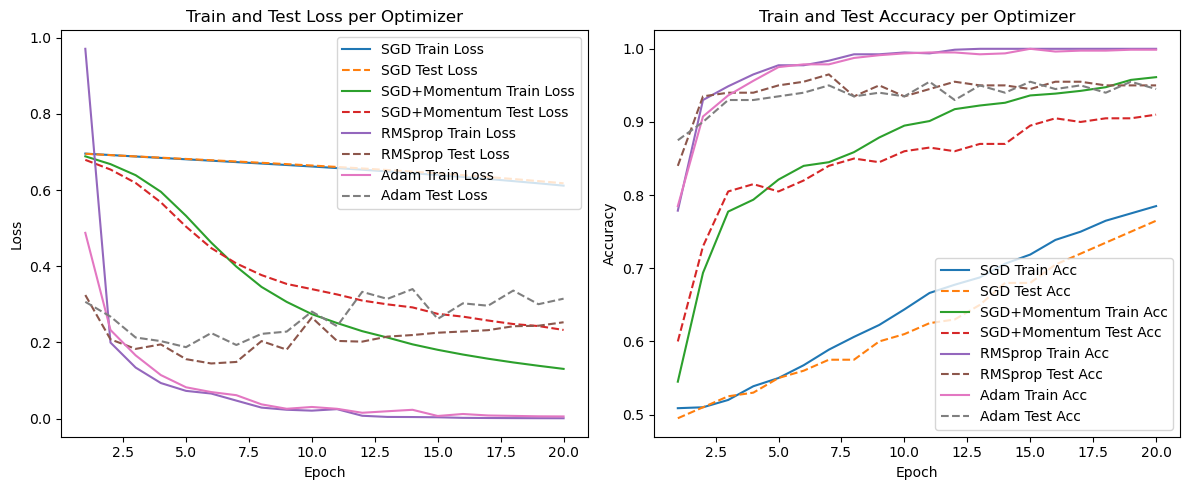

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot Train and Test Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for opt_name in logs:
    plt.plot(epochs, logs[opt_name]['train_loss'], label=f'{opt_name} Train Loss')
    plt.plot(epochs, logs[opt_name]['test_loss'], linestyle='--', label=f'{opt_name} Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss per Optimizer')
plt.legend()

# Plot Train and Test Accuracy
plt.subplot(1,2,2)
for opt_name in logs:
    plt.plot(epochs, logs[opt_name]['train_acc'], label=f'{opt_name} Train Acc')
    plt.plot(epochs, logs[opt_name]['test_acc'], linestyle='--', label=f'{opt_name} Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy per Optimizer')
plt.legend()

plt.tight_layout()
plt.show()


Model trained with Adam saved as 'best_model_adam.pth'
Test loss: 0.3150, Test accuracy: 0.9450


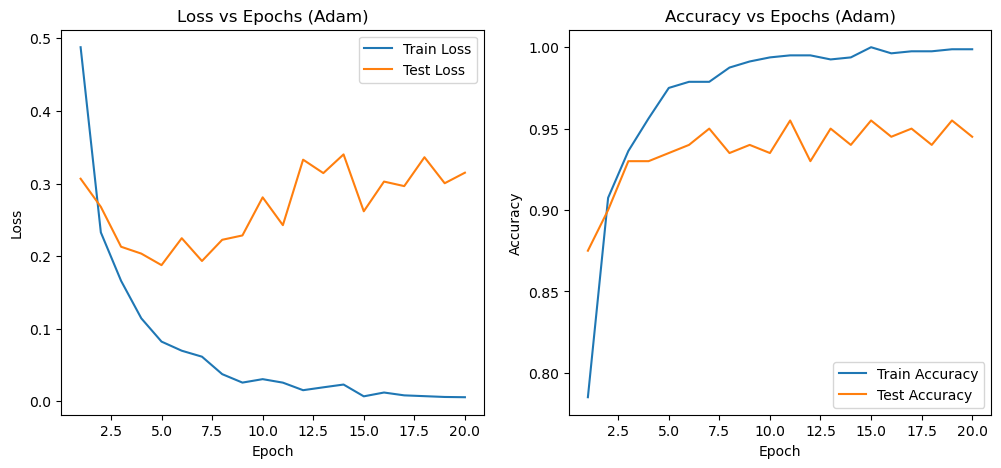

In [16]:
import matplotlib.pyplot as plt
import torch

#saving the best model (trained with Adam)
torch.save(model.state_dict(), 'best_model_adam.pth')
print("Model trained with Adam saved as 'best_model_adam.pth'")

best_model = TwoHiddenLayerNN(input_size, hidden1, hidden2, num_classes)
best_model.load_state_dict(torch.load('best_model_adam.pth'))
best_model.to(device)
best_model.eval()

test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

train_losses = logs['Adam']['train_loss']
train_accs = logs['Adam']['train_acc']
test_losses = logs['Adam']['test_loss']
test_accs = logs['Adam']['test_acc']

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Adam)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs (Adam)')
plt.legend()

plt.show()
